In [1]:
import json 
from os import listdir
from numpy import zeros
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from numpy import asarray
from mrcnn.utils import Dataset
from matplotlib import pyplot

In [2]:
import json # import json module
filename = "./underline/train/annots/1.json"
with open(filename) as json_file:
    json_data = json.load(json_file)

boxes = list()

for box in json_data['shapes']:
    coor = box['points']
    x_min, y_min = coor[0]
    x_max, y_max = coor[1]
    coors = [x_min,y_min,x_max,y_max]
    boxes.append(coors)

width = json_data['imageHeight']
height = json_data['imageWidth']


FileNotFoundError: [Errno 2] No such file or directory: './underline/train/annots/1.json'

In [3]:
list(json_data)

NameError: name 'json_data' is not defined

In [4]:

class KangarooDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "underline")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in listdir(images_dir):
        # extract image id
            image_id = filename[:-4]
        # skip bad images
            if image_id in ['00090']:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.json'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
    
    def extract_boxes(self, filename):
    # with statement
        with open(filename) as json_file:
            json_data = json.load(json_file)

        boxes = list()

        for box in json_data['shapes']:
            coor = box['points']
            x_min, y_min = coor[0]
            x_max, y_max = coor[1]
            coors = [x_min,y_min,x_max,y_max]
            boxes.append(coors)

        width = json_data['imageHeight']
        height = json_data['imageWidth']
        return boxes, width, height
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        # print(info)
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = int(box[1]), int(box[3])
            col_s, col_e = int(box[0]), int(box[2])
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('underline'))
        return masks, asarray(class_ids, dtype='int32')
 
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [5]:
train_set = KangarooDataset()
train_set.load_dataset('./underline2/train', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# test/val set
test_set = KangarooDataset()
test_set.load_dataset('./underline2/test', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 7
Test: 1


In [6]:
# load an image
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

(2636, 1908, 3)
(1908, 2636, 158)


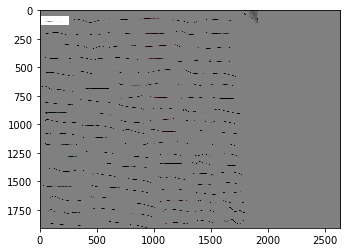

In [7]:
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()

In [9]:
# plot first few images
for i in range(5):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    image = train_set.load_image(i)
    pyplot.imshow(image)
    # plot all masks
    mask, _ = train_set.load_mask(i)
    for j in range(mask.shape[2]):
        pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
# show the figure
pyplot.show()

KeyboardInterrupt: 

In [8]:
# enumerate all images in the dataset
for image_id in train_set.image_ids:
    # load image info
    info = train_set.image_info[image_id]
    # display on the console
    print(info)

{'id': '4', 'source': 'dataset', 'path': './underline2/train/images/4.jpg', 'annotation': './underline2/train/annots/4.json'}
{'id': '6', 'source': 'dataset', 'path': './underline2/train/images/6.jpg', 'annotation': './underline2/train/annots/6.json'}
{'id': '5', 'source': 'dataset', 'path': './underline2/train/images/5.jpg', 'annotation': './underline2/train/annots/5.json'}
{'id': '7', 'source': 'dataset', 'path': './underline2/train/images/7.jpg', 'annotation': './underline2/train/annots/7.json'}
{'id': '2', 'source': 'dataset', 'path': './underline2/train/images/2.jpg', 'annotation': './underline2/train/annots/2.json'}
{'id': '3', 'source': 'dataset', 'path': './underline2/train/images/3.jpg', 'annotation': './underline2/train/annots/3.json'}
{'id': '1', 'source': 'dataset', 'path': './underline2/train/images/1.jpg', 'annotation': './underline2/train/annots/1.json'}


In [9]:
from os import listdir
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

In [10]:
from mrcnn.config import Config
# define a configuration for the model
class KangarooConfig(Config):
    # Give the configuration a recognizable name
    NAME = "kangaroo_cfg"
    # Number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 5
 
# prepare config
config = KangarooConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [11]:
from mrcnn.model import MaskRCNN
model = MaskRCNN(mode='training', model_dir='./', config=config)

Using TensorFlow backend.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [12]:
# load weights (mscoco)
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=15, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./kangaroo_cfg20191118T0145/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         

/home/fluffy/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/fluffy/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/fluffy/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/home/fluffy/anaconda3/envs/tf/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
4/5 [=======================>......] - ETA: 20s - loss: 6.9600

In [14]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "kangaroo_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    # load image and mask
    for i in range(n_images):
    # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        pyplot.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        pyplot.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Predicted')
        ax = pyplot.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
        ax.add_patch(rect)
    # show the figure
    pyplot.show()

In [ ]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

In [ ]:
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model_path = 'mask_rcnn_kangaroo_cfg_0005.h5'
model.load_weights(model_path, by_name=True)

In [16]:
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)

True